# Approach 1: Multi-Layer Perceptron; Neural Network

Curse: IS4242, Semster 1, 2024

Team: LLP


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

## Preparaing and data engineering
The train and test dataframe contains merged data of all data based on user_id and item_id as foreign key.


In [2]:
df_train = pd.read_csv('data/train.csv', index_col=None)
df_test = pd.read_csv('data/test.csv', index_col=None)
display(df_train.head())
display(df_test.head())
display(df_train.info())
display(df_test.info())

,user_id,item_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,1,5,24,M,technician,Arizona,1995.0,Animation
1,1,2,3,24,M,technician,Arizona,1995.0,Action
2,1,3,4,24,M,technician,Arizona,1995.0,Thriller
3,1,4,3,24,M,technician,Arizona,1995.0,Action
4,1,5,3,24,M,technician,Arizona,1995.0,Crime


,user_id,item_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,20,4,24,M,technician,Arizona,1995.0,Drama
1,1,33,4,24,M,technician,Arizona,1995.0,Action
2,1,61,4,24,M,technician,Arizona,1994.0,Drama
3,1,117,3,24,M,technician,Arizona,1996.0,Action
4,1,155,2,24,M,technician,Arizona,1987.0,Musical


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          90570 non-null  int64  
 1   item_id          90570 non-null  int64  
 2   rating           90570 non-null  int64  
 3   user_age         90570 non-null  int64  
 4   user_gender      90570 non-null  object 
 5   user_occupation  90570 non-null  object 
 6   user_zip         90570 non-null  object 
 7   release_date     90562 non-null  float64
 8   genre            90570 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9430 entries, 0 to 9429
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          9430 non-null   int64  
 1   item_id          9430 non-null   int64  
 2   rating           9430 non-null   int64  
 3   user_age         9430 non-null   int64  
 4   user_gender      9430 non-null   object 
 5   user_occupation  9430 non-null   object 
 6   user_zip         9430 non-null   object 
 7   release_date     9429 non-null   float64
 8   genre            9430 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 663.2+ KB


None

In [3]:
# Drop user_id and item_id for train and test data set
df_train = df_train.drop(['user_id', 'item_id'], axis=1)
df_test = df_test.drop(['user_id', 'item_id'], axis=1)


In [4]:
df_train = df_train.dropna(subset=['release_date'])
df_test = df_test.dropna(subset=['release_date'])

In [5]:
# Turn year into int
df_train['release_date'] = df_train['release_date'].astype(int)
df_test['release_date'] = df_test['release_date'].astype(int)

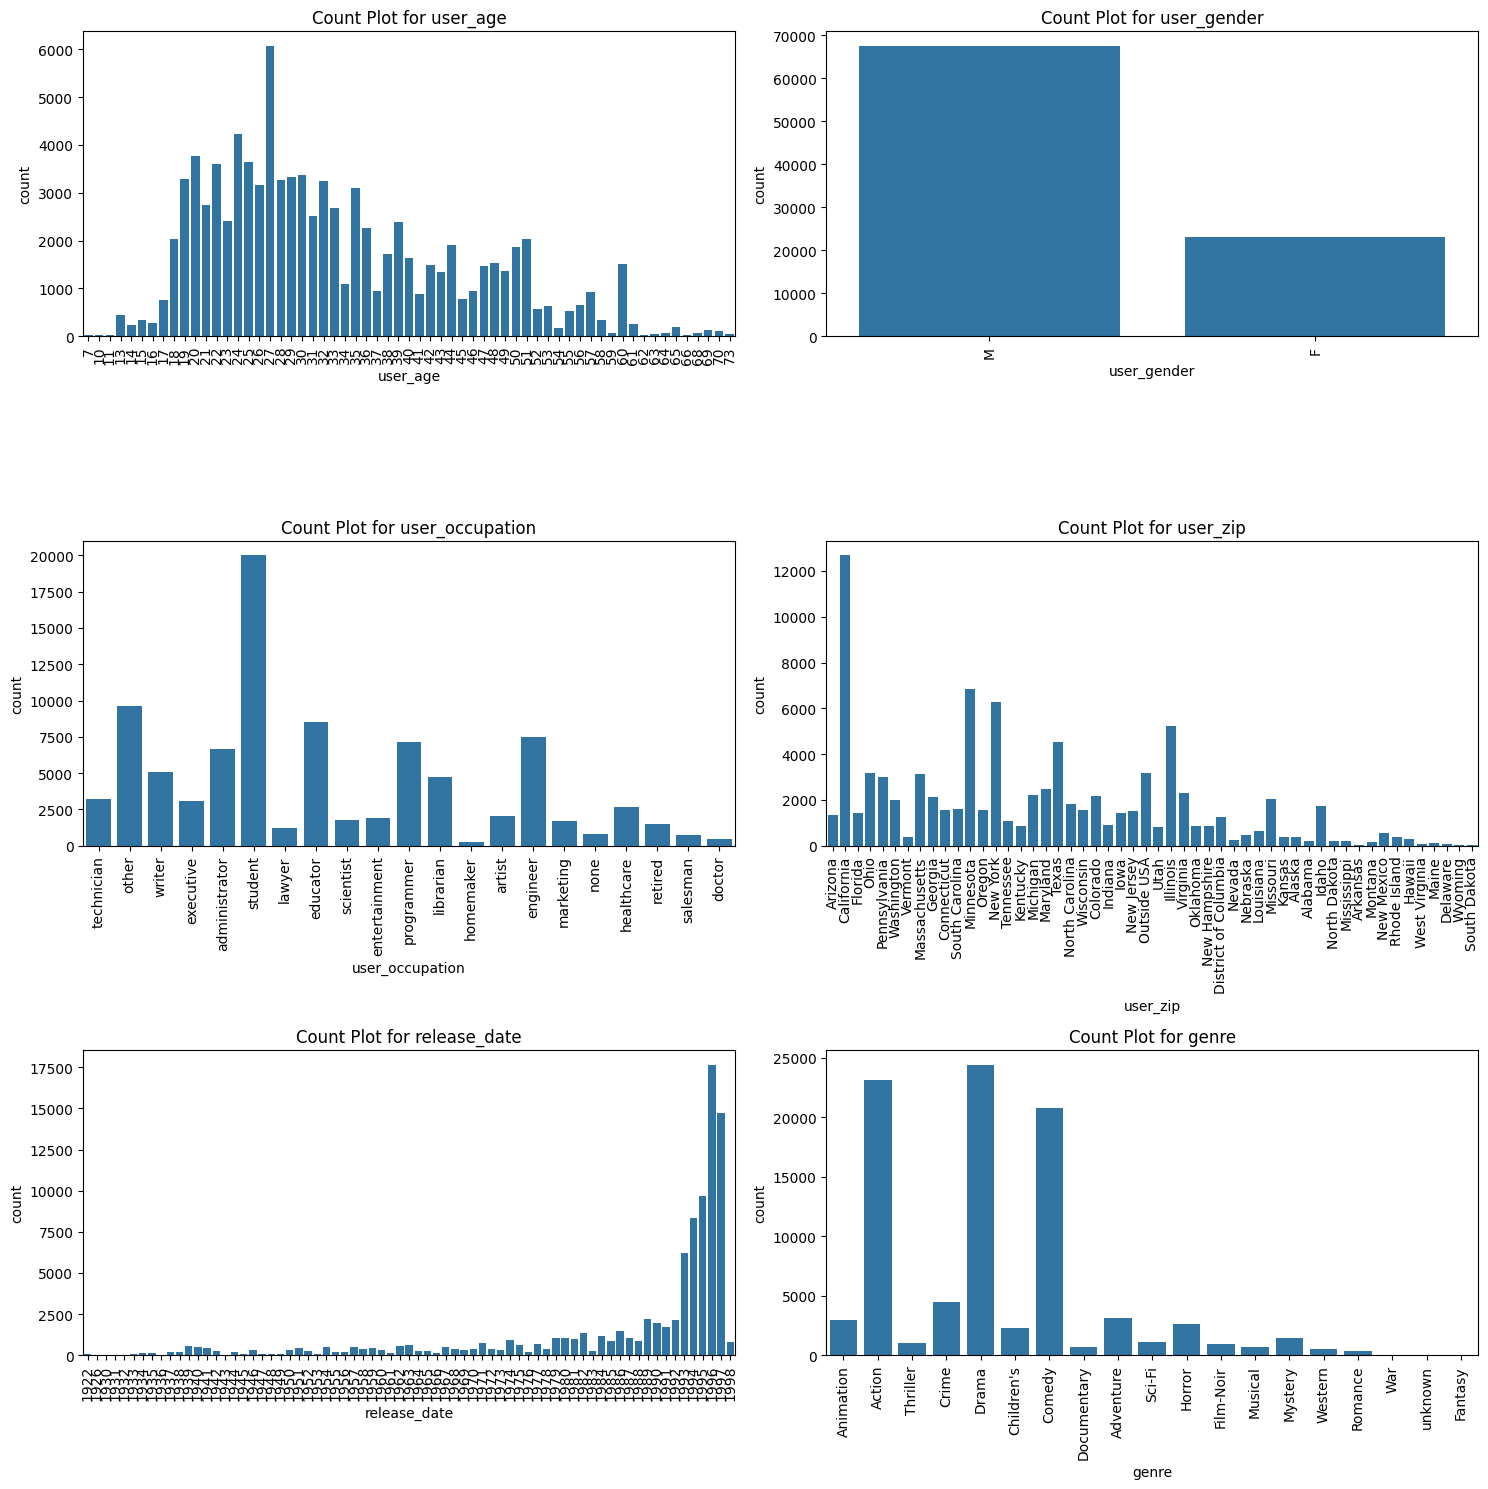

In [6]:
features = [col for col in df_train.columns if col != 'rating']

# Number of features
num_features = len(features)

# Calculate the number of rows and columns for subplots
nrows = (num_features + 1) // 2
ncols = 2

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot count plots for each feature
for i, feature in enumerate(features):
    sns.countplot(x=feature, data=df_train, ax=axes[i])
    axes[i].set_title(f'Count Plot for {feature}')
    plt.setp(axes[i].get_xticklabels(), rotation=90)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### Manually label like or dislike

In [7]:
# Add a new column 'like_dislike' to df_train and df_test based on the rating
df_train['like_dislike'] = df_train['rating'].apply(lambda x: 1 if x >= 4 else 0)
df_test['like_dislike'] = df_test['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Display the first few rows to verify the new column
display(df_train.head())
display(df_test.head())

,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre,like_dislike
0,5,24,M,technician,Arizona,1995,Animation,1
1,3,24,M,technician,Arizona,1995,Action,0
2,4,24,M,technician,Arizona,1995,Thriller,1
3,3,24,M,technician,Arizona,1995,Action,0
4,3,24,M,technician,Arizona,1995,Crime,0


,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre,like_dislike
0,4,24,M,technician,Arizona,1995,Drama,1
1,4,24,M,technician,Arizona,1995,Action,1
2,4,24,M,technician,Arizona,1994,Drama,1
3,3,24,M,technician,Arizona,1996,Action,0
4,2,24,M,technician,Arizona,1987,Musical,0


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pandas as pd
import numpy as np


In [9]:
df = df_train.copy()

# One-hot encoding for gender
gender_ohe = pd.get_dummies(df['user_gender'], drop_first=True)  # Drop first to avoid collinearity
df = pd.concat([df, gender_ohe], axis=1) 

# Encoding categorical features
categorical_cols = ['genre', 'user_occupation', 'user_zip']
oe = OrdinalEncoder()
df[categorical_cols] = oe.fit_transform(df[categorical_cols])

# Handling numerical features
# Step 3: Standardization for numerical features (age, income)
scaler = StandardScaler()
df[['user_age', 'rating', 'release_date']] = scaler.fit_transform(df[['user_age', 'rating', 'release_date']])

# Separate categorical, numerical, and one-hot encoded gender
X_categorical = df[categorical_cols].values  # Ordinal encoded categorical data
X_numerical = df[['user_age', 'rating', 'release_date']].values   # Scaled numerical data
X_gender = df[['M']].values  # One-hot encoded gender (only one column 'Male' due to drop_first=True)

# Convert labels
y = df['like_dislike'].values


In [10]:
# Convert data to PyTorch tensors
X_categorical_tensor = torch.tensor(X_categorical, dtype=torch.long)
X_numerical_tensor = torch.tensor(X_numerical, dtype=torch.float32)
X_gender_tensor = torch.tensor(X_gender, dtype=torch.float32) 
y_tensor = torch.tensor(y, dtype=torch.long) 

In [11]:
# Define the model
class MixedInputModelWithGender(nn.Module):
    def __init__(self, genre_vocab_size, occupation_vocab_size, zip_vocab_size, embedding_dim, num_numerical_features, num_gender_features):
        super(MixedInputModelWithGender, self).__init__()
        
        # Embedding layers for categorical features
        self.genre_embedding = nn.Embedding(genre_vocab_size, embedding_dim)
        self.occupation_embedding = nn.Embedding(occupation_vocab_size, embedding_dim)
        self.zip_embedding = nn.Embedding(zip_vocab_size, embedding_dim)
        
        # Fully connected layers (adjusting input size to include gender one-hot features)
        self.fc1 = nn.Linear(embedding_dim * 3 + num_numerical_features + num_gender_features, 128)  # Including gender
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # For binary classification (1 output with sigmoid)
    
    def forward(self, X_categorical, X_numerical, X_gender):
        # Embeddings for categorical features
        genre_embedded = self.genre_embedding(X_categorical[:, 0])  # First column: genre
        occupation_embedded = self.occupation_embedding(X_categorical[:, 1])  # Second column: occupation
        zip_embedded = self.zip_embedding(X_categorical[:, 2])  # Third column: zip
        
        # Concatenate embeddings, numerical features, and one-hot encoded gender
        x = torch.cat([genre_embedded, occupation_embedded, zip_embedded, X_numerical, X_gender], dim=1)
        
        # Pass through fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        
        return output

In [12]:
# Initialize the model
model = MixedInputModelWithGender(
    genre_vocab_size=len(oe.categories_[0]),  # Number of unique genres
    occupation_vocab_size=len(oe.categories_[1]),  # Number of unique occupations
    zip_vocab_size=len(oe.categories_[2]),  # Number of unique states
    embedding_dim=8,  # Embedding size
    num_numerical_features=3,  # Number of numerical features (age, income)
    num_gender_features=1  # Number of one-hot encoded gender features (only 1 after drop_first=True)
)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert y_tensor to float for BCELoss (binary cross-entropy loss expects float labels)
y_tensor = y_tensor.float()



In [13]:
# Training loop
epochs = 100
train_threshold = 0.5
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_categorical_tensor, X_numerical_tensor, X_gender_tensor)
    loss = criterion(outputs, y_tensor.unsqueeze(1))  
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

    if loss < train_threshold:
        break

    # if (epoch+1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1], Loss: 0.7037
Epoch [2], Loss: 0.6930
Epoch [3], Loss: 0.6831
Epoch [4], Loss: 0.6739
Epoch [5], Loss: 0.6651
Epoch [6], Loss: 0.6565
Epoch [7], Loss: 0.6479
Epoch [8], Loss: 0.6393
Epoch [9], Loss: 0.6304
Epoch [10], Loss: 0.6212
Epoch [11], Loss: 0.6116
Epoch [12], Loss: 0.6016
Epoch [13], Loss: 0.5910
Epoch [14], Loss: 0.5800
Epoch [15], Loss: 0.5684
Epoch [16], Loss: 0.5563
Epoch [17], Loss: 0.5438
Epoch [18], Loss: 0.5309
Epoch [19], Loss: 0.5175
Epoch [20], Loss: 0.5038
Epoch [21], Loss: 0.4898


### Evaluate on model

First turn test data set into tensor

In [14]:
df = df_test.copy()
# One-hot encoding for gender
gender_ohe = pd.get_dummies(df['user_gender'], drop_first=True)  # Drop first to avoid collinearity
df = pd.concat([df, gender_ohe], axis=1) 

# Encoding categorical features
categorical_cols = ['genre', 'user_occupation', 'user_zip']
oe = OrdinalEncoder()
df[categorical_cols] = oe.fit_transform(df[categorical_cols])

# Handling numerical features
# Step 3: Standardization for numerical features (age, income)
scaler = StandardScaler()
df[['user_age', 'rating', 'release_date']] = scaler.fit_transform(df[['user_age', 'rating', 'release_date']])

# Separate categorical, numerical, and one-hot encoded gender
test_X_categorical = df[categorical_cols].values  # Ordinal encoded categorical data
test_X_numerical = df[['user_age', 'rating', 'release_date']].values   # Scaled numerical data
test_X_gender = df[['M']].values  # One-hot encoded gender (only one column 'Male' due to drop_first=True)

# Convert labels
test_y = df['like_dislike'].values

# Convert data to PyTorch tensors
test_X_categorical_tensor = torch.tensor(test_X_categorical, dtype=torch.long)
test_X_numerical_tensor = torch.tensor(test_X_numerical, dtype=torch.float32)
test_X_gender_tensor = torch.tensor(test_X_gender, dtype=torch.float32) 
test_y_tensor = torch.tensor(test_y, dtype=torch.long) 

Evaluate on the model with test tensor

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,roc_curve

def calculate_youden_index(fpr, tpr, thresholds):
    youden_index = tpr - fpr
    optimal_threshold_index = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_threshold_index]
    return optimal_threshold

def evaluate_model(model, X_categorical_tensor, X_numerical_tensor, X_gender_tensor, y_true_tensor):
    model.eval()  # Set model to evaluation mode
    # threshold = 0.5  # Threshold for binary classification
    with torch.no_grad():  # Disable gradient calculations for evaluation
        # Forward pass to get predictions
        y_pred_probs = model(X_categorical_tensor, X_numerical_tensor, X_gender_tensor)
        
        # Convert tensors to NumPy arrays for metric calculations
        y_true = y_true_tensor.numpy()
        y_pred_probs = y_pred_probs.numpy()
        
         # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
        
        # Calculate optimal threshold using Youden's Index
        optimal_threshold = calculate_youden_index(fpr, tpr, thresholds)
        print(f'Optimal Threshold: {optimal_threshold}')

        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        y_pred = (y_pred_probs >= optimal_threshold).astype(float)
        # Calculate evaluation metrics
        # accuracy = accuracy_score(y_true, y_pred)
        # precision = precision_score(y_true, y_pred)
        # recall = recall_score(y_true, y_pred)
        # f1 = f1_score(y_true, y_pred)
        
        # Detailed classification report
        report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
        print(report)
        
    # return accuracy, precision, recall, f1


# Example usage of the evaluation function
evaluate_model(model, test_X_categorical_tensor, test_X_numerical_tensor, test_X_gender_tensor, test_y_tensor)

Optimal Threshold: 0.546326220035553
              precision    recall  f1-score   support

     Class 0       0.85      0.91      0.88      3961
     Class 1       0.93      0.89      0.91      5468

    accuracy                           0.90      9429
   macro avg       0.89      0.90      0.90      9429
weighted avg       0.90      0.90      0.90      9429

